In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

c:\Python\Python3.10.5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # String to Int
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Int to String
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# . . . e --- m 
# . . e m --- m 
# . e m m --- a
# e m m a --- . 

# Functions

Generating context and labels

In [6]:
def build_dataset(words, block_size):
    """
    Build a dataset of the words using the block size of characters as the
    samples and the next character as the label.
    """

    # context length of characters taken to predict the next 
    X, Y = [],[]

    for w in words:
        
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def get_loss(c, xs, ys, nembs, block_size, w1, b1, w2, b2):
    emb = c[xs]
    h = torch.tanh(emb.view(-1, nembs*block_size) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, ys)
    return loss

def generate_names(c, n_names:int, block_size, w1, b1, w2, b2, g):
    out = []
    for _ in range(n_names):
        name = []
        
        context = [0] * block_size
        while True:
            emb = c[torch.tensor([context])]
            h = torch.tanh(emb.view(1, -1) @ w1 + b1)
            logits = h @ w2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            name.append(ix)
            if ix == 0:
                break
        

        out.append(name)
    
    return(out)


# Making it more respecatble

In [7]:
# EMB = 30
# BLOCK_SIZE = 3
# BATCH_SIZE = 32
# EPOCHS = 20000

# random.seed(42)
# random.shuffle(words)
# n1 = int(0.8*len(words))
# n2 = int(0.9*len(words)) 
# Xtrain, Ytrain = build_dataset(words[:n1], BLOCK_SIZE)
# Xdev, Ydev = build_dataset(words[n1:n2], BLOCK_SIZE)
# Xtest, Ytest = build_dataset(words[n2:], BLOCK_SIZE)

# g = torch.Generator().manual_seed(2147483647)

# c = torch.randn((27, EMB), generator=g)
# w1 = torch.randn((BLOCK_SIZE*EMB, 200), generator=g)
# b1 = torch.randn((200), generator=g)
# w2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn((27), generator=g)

# parameters = [c, w1, b1, w2, b2]
# nparameters = sum(p.nelement() for p in parameters)
# print(nparameters)

# for p in parameters:
#     p.requires_grad = True


# for i in range(EPOCHS):
#     # minibatch construct
#     ix = torch.randint(0, Xtrain.shape[0], (BATCH_SIZE,))
#     # forward pass
#     emb = c[Xtrain[ix]]
#     h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMB) @ w1 + b1)
#     logits = h @ w2 + b2
#     loss = F.cross_entropy(logits, Ytrain[ix])
#     # backward pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     # update
#     lr = 0.01 if i < EPOCHS//2 else 0.01
#     for p in parameters:
#         p.data += -lr  * p.grad

In [8]:
# g = torch.Generator().manual_seed(2147483647+ 10) 
# names = generate_names(c, 10, BLOCK_SIZE, w1, b1, w2, b2, g)

# for name in names:
#     print(''.join(itos[i] for i in name))

# Experiments

Effect of number of embeddings on training loss

In [9]:
# lossi = []

# n_embs = [x+1 for x in range(30)]
# n_steps = EPOCHS

# for n_emb in n_embs:

#     g = torch.Generator().manual_seed(2147483647)
#     c = torch.randn((27, n_emb), generator=g)
#     w1 = torch.randn((n_emb * BLOCK_SIZE, 200), generator=g)
#     b1 = torch.randn((200), generator=g)
#     w2 = torch.randn((200, 27), generator=g)
#     b2 = torch.randn((27), generator=g)

#     parameters = [c, w1, b1, w2, b2]
#     nparameters = sum(p.nelement() for p in parameters)
#     print('-------')
#     print(f'{nparameters=}')
#     print(f"{n_emb} embeddings")
#     print('-------')

#     for p in parameters:
#         p.requires_grad = True

#     losses = []
#     avg_loss = 0
#     temp_loss = 0
#     for i in range(EPOCHS + 1):
#         # minibatch construct
#         ix = torch.randint(0, Xdev.shape[0], (BATCH_SIZE,))
#         # forward pass
#         emb = c[Xdev[ix]]
#         h = torch.tanh(emb.view(-1, BLOCK_SIZE*n_emb) @ w1 + b1)
#         logits = h @ w2 + b2
#         loss = F.cross_entropy(logits, Ydev[ix])
#         # backward pass
#         for p in parameters:
#             p.grad = None
#         loss.backward()
#         # update
#         lr = 0.01 if i < EPOCHS//2 else 0.01
#         for p in parameters:
#             p.data += -lr  * p.grad
#         # track stats

#         temp_loss += loss.item()

#         if i%(EPOCHS//10) == 0:
#             print(f"Epochs: {i}")
            
#             if i != 0:
#                 avg_loss = temp_loss/(EPOCHS//10)
#                 print(avg_loss)
#                 losses.append(avg_loss)

#             temp_loss = 0
            
#             #print(f"{loss.item()}")

        
#     lossi.append(min(losses))

4 or 5 seems like a good number here

In [10]:
# EMB = 4
# BLOCK_SIZE = 3
# BATCH_SIZE = 32
# EPOCHS = 100000

# dev_loss = []
# test_loss = []
# hidden_layer_lengths = [10 * (x + 20) for x in range(10)]

# for hidden_layer_length in hidden_layer_lengths:

#     g = torch.Generator().manual_seed(2147483647)
#     c = torch.randn((27, EMB), generator=g)
#     w1 = torch.randn((EMB * BLOCK_SIZE, hidden_layer_length), generator=g)
#     b1 = torch.randn((hidden_layer_length), generator=g)
#     w2 = torch.randn((hidden_layer_length, 27), generator=g)
#     b2 = torch.randn((27), generator=g)

#     parameters = [c, w1, b1, w2, b2]
#     nparameters = sum(p.nelement() for p in parameters)
#     print('-------')
#     print(f'{nparameters=}')
#     print(f'{hidden_layer_length=}')
#     print('-------')

#     for p in parameters:
#         p.requires_grad = True

#     dev_lossi = []
#     dev_loss_avg = 0
#     dev_loss_temp = 0

#     test_lossi = []
#     test_loss_avg = 0
#     test_loss_temp = 0

#     for i in range(EPOCHS + 1):
#         # minibatch construct
#         ix = torch.randint(0, Xdev.shape[0], (BATCH_SIZE,))
#         # forward pass
#         emb = c[Xdev[ix]]
#         h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMB) @ w1 + b1)
#         logits = h @ w2 + b2
#         loss = F.cross_entropy(logits, Ydev[ix])
#         # backward pass
#         for p in parameters:
#             p.grad = None
#         loss.backward()
#         # update
#         lr = 0.1 if i < EPOCHS//2 else 0.01
#         for p in parameters:
#             p.data += -lr  * p.grad
#         # track stats

#         dev_loss_temp += loss.item()

#         test_loss_temp += get_loss(c, Xtest, Ytest, EMB, BLOCK_SIZE, w1, b1, w2, b2).item()

#         if i%(EPOCHS//10) == 0:
#             print(f"Epochs: {i}")

#             if i != 0:
#                 dev_loss_avg = dev_loss_temp/(EPOCHS//10)
#                 print(f"Average dev loss: {dev_loss_avg:.6f}")
#                 dev_lossi.append(dev_loss_avg)

#                 test_loss_avg = test_loss_temp/(EPOCHS//10)
#                 print(f'Average test loss: {test_loss_avg:.6f}')
#                 test_lossi.append(test_loss_avg)

#             dev_loss_temp = 0
#             test_loss_temp = 0

#     dev_loss.append(min(dev_lossi))
#     test_loss.append(min(test_lossi))


In [11]:
# #plt.plot(step, test_loss)
# plt.plot(step, dev_loss)
# plt.legend(['test_loss', 'dev_loss'])


Around 200 to 250 seemed good on the first pass. 260 ended up being the best when doing a more finely spaced analysis.

In [12]:
# EMB = 4
# BLOCK_SIZE = 3
# HIDDEN_LAYER_LENGTH = 260
# EPOCHS = 10000

# dev_loss = []
# test_loss = []
# batch_sizes = [2**(x+3) for x in range(10)] 


# for batch_size in batch_sizes:

#     g = torch.Generator().manual_seed(2147483647)
#     c = torch.randn((27, EMB), generator=g)
#     w1 = torch.randn((EMB * BLOCK_SIZE, HIDDEN_LAYER_LENGTH), generator=g)
#     b1 = torch.randn((HIDDEN_LAYER_LENGTH), generator=g)
#     w2 = torch.randn((HIDDEN_LAYER_LENGTH, 27), generator=g)
#     b2 = torch.randn((27), generator=g)

#     parameters = [c, w1, b1, w2, b2]
#     nparameters = sum(p.nelement() for p in parameters)
#     print(f'{nparameters} parameters')
#     print(f'Batch size: {batch_size}')
#     print(f'--------')

#     for p in parameters:
#         p.requires_grad = True

#     dev_lossi = []
#     dev_loss_avg = 0
#     dev_loss_temp = 0

#     test_lossi = []
#     test_loss_avg = 0
#     test_loss_temp = 0

#     for i in range(EPOCHS + 1):
#         # minibatch construct
#         ix = torch.randint(0, Xdev.shape[0], (batch_size,))
#         # forward pass
#         emb = c[Xdev[ix]]
#         h = torch.tanh(emb.view(-1, BLOCK_SIZE*EMB) @ w1 + b1)
#         logits = h @ w2 + b2
#         loss = F.cross_entropy(logits, Ydev[ix])
#         # backward pass
#         for p in parameters:
#             p.grad = None
#         loss.backward()
#         # update
#         lr = 0.1 if i < EPOCHS//2 else 0.01
#         for p in parameters:
#             p.data += -lr  * p.grad
#         # track stats
#         dev_loss_temp += loss.item()
#         test_loss_temp += get_loss(c, Xtest, Ytest, EMB, BLOCK_SIZE, w1, b1, w2, b2).item()


#         if i%(EPOCHS//10) == 0:
#             print(f"Epochs: {i}")

            

#             if i != 0:
#                 dev_loss_avg = dev_loss_temp/(EPOCHS//10)
#                 print(f"Average dev loss: {dev_loss_avg:.6f}")
#                 dev_lossi.append(dev_loss_avg)

#                 test_loss_avg = test_loss_temp/(EPOCHS//10)
#                 print(f'Average test loss: {test_loss_avg:.6f}')
#                 test_lossi.append(test_loss_avg)
#             else:
#                 print(f'Starting dev loss: {dev_loss_temp:.6f}')
#                 print(f'Starting test loss: {test_loss_temp:.6f}')

#             dev_loss_temp = 0
#             test_loss_temp = 0

#     dev_loss.append(min(dev_lossi))
#     test_loss.append(min(test_lossi))

In [13]:
# plt.plot(batch_sizes, test_loss)
# plt.plot(batch_sizes, dev_loss)
# plt.legend(['test_loss', 'dev_loss'])
# plt.xscale('log')
# plt.xticks(batch_sizes, batch_sizes)

A batch size of 64 seems to be a good value here. Moving on to block size.

In [14]:
# EMB = 4
# BATCH_SIZE = 64
# BLOCK_SIZE = 4
# HIDDEN_LAYER_LENGTH = 260
# EPOCHS = 10000

# dev_loss = []
# test_loss = []
# block_sizes = [x for x in range(2, 7)]

# for block_size in block_sizes:

#     random.seed(42)
#     random.shuffle(words)
#     n1 = int(0.8*len(words))
#     n2 = int(0.9*len(words)) 
#     Xtrain, Ytrain = build_dataset(words[:n1], block_size)
#     Xdev, Ydev = build_dataset(words[n1:n2], block_size)
#     Xtest, Ytest = build_dataset(words[n2:], block_size)

#     g = torch.Generator().manual_seed(2147483647)
#     c = torch.randn((27, EMB), generator=g)
#     w1 = torch.randn((EMB * block_size, HIDDEN_LAYER_LENGTH), generator=g)
#     b1 = torch.randn((HIDDEN_LAYER_LENGTH), generator=g)
#     w2 = torch.randn((HIDDEN_LAYER_LENGTH, 27), generator=g)
#     b2 = torch.randn((27), generator=g)

#     parameters = [c, w1, b1, w2, b2]
#     nparameters = sum(p.nelement() for p in parameters)
#     print(f'{nparameters} parameters')
#     print(f'Block size: {block_size}')
#     print(f'--------')

#     for p in parameters:
#         p.requires_grad = True

#     dev_lossi = []
#     dev_loss_avg = 0
#     dev_loss_temp = 0

#     test_lossi = []
#     test_loss_avg = 0
#     test_loss_temp = 0

#     for i in range(EPOCHS + 1):
#         # minibatch construct
#         ix = torch.randint(0, Xdev.shape[0], (BATCH_SIZE,))
#         # forward pass
#         emb = c[Xdev[ix]]
#         h = torch.tanh(emb.view(-1, block_size*EMB) @ w1 + b1)
#         logits = h @ w2 + b2
#         loss = F.cross_entropy(logits, Ydev[ix])
#         # backward pass
#         for p in parameters:
#             p.grad = None
#         loss.backward()
#         # update
#         lr = 0.1 if i < EPOCHS//2 else 0.01
#         for p in parameters:
#             p.data += -lr  * p.grad
#         # track stats
#         dev_loss_temp += loss.item()
#         test_loss_temp += get_loss(c, Xtest, Ytest, EMB, block_size, w1, b1, w2, b2).item()


#         if i%(EPOCHS//10) == 0:
#             print(f"Epochs: {i}")

            

#             if i != 0:
#                 dev_loss_avg = dev_loss_temp/(EPOCHS//10)
#                 print(f"Average dev loss: {dev_loss_avg:.6f}")
#                 dev_lossi.append(dev_loss_avg)

#                 test_loss_avg = test_loss_temp/(EPOCHS//10)
#                 print(f'Average test loss: {test_loss_avg:.6f}')
#                 test_lossi.append(test_loss_avg)
#             else:
#                 print(f'Starting dev loss: {dev_loss_temp:.6f}')
#                 print(f'Starting test loss: {test_loss_temp:.6f}')

#             dev_loss_temp = 0
#             test_loss_temp = 0

#     dev_loss.append(min(dev_lossi))
#     test_loss.append(min(test_lossi))

In [15]:
# plt.plot(block_sizes, test_loss)
# plt.plot(block_sizes, dev_loss)
# plt.legend(['test_loss', 'dev_loss'])
# plt.xticks(block_sizes, block_sizes)

4 seems to be the best here

Ive increased the batch size in proportion to the size of the training set compared with the dev set.

Everything has been messed with since i ran the experments to try optimize

In [16]:
EMB = 60
BATCH_SIZE = 512
BLOCK_SIZE = 5
HIDDEN_LAYER_LENGTH = 50
EPOCHS = 100000
EVAL_INTERVAL = EPOCHS//10

In [17]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words)) 
Xtrain, Ytrain = build_dataset(words[:n1], BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2], BLOCK_SIZE)
Xtest, Ytest = build_dataset(words[n2:], BLOCK_SIZE)

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [18]:
g = torch.Generator().manual_seed(2147483647)

c = torch.randn((27, EMB), generator=g)
w1 = torch.randn((EMB * BLOCK_SIZE, HIDDEN_LAYER_LENGTH), generator=g)
b1 = torch.randn((1,HIDDEN_LAYER_LENGTH), generator=g)
w2 = torch.randn((HIDDEN_LAYER_LENGTH, 27), generator=g)
b2 = torch.randn((1,27), generator=g)


# c1 = torch.full((27, 1), 0.25)
# c2 = torch.full((27, 1), 0.50)
# c3 = torch.full((27, 1), 0.75)
# c4 = torch.full((27, 1), 1.0)

# c = torch.cat((c1,c2,c3,c4), dim=1)
# w1 = torch.full((EMB * BLOCK_SIZE, HIDDEN_LAYER_LENGTH))
# b1 = torch.full((1,HIDDEN_LAYER_LENGTH))
# w2 = torch.full((HIDDEN_LAYER_LENGTH, 27))
# b2 = torch.full((1,27))

parameters = [c, w1, b1, w2, b2]
nparameters = sum(p.nelement() for p in parameters)
print(f'{nparameters} parameters')

for p in parameters:
    p.requires_grad = True

train_loss = []

r = 10**-6
e0 = 10**-2

for i in range(EPOCHS + 1):
    # minibatch construct
    if i < int(0.95 * EPOCHS):
        ix = torch.randint(0, Xtrain.shape[0], (BATCH_SIZE,))
        emb = c[Xtrain[ix]]
    else:
        emb = c[Xtrain]
    # forward pass
    h = torch.tanh(emb.view(-1, EMB * BLOCK_SIZE) @ w1 + b1)
    logits = h @ w2 + b2
    if i < int(0.95 * EPOCHS):
        loss = F.cross_entropy(logits, Ytrain[ix])
    else:
        loss = F.cross_entropy(logits, Ytrain)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = e0 * (1 + i*r) ** -1
    
    for p in parameters:
        p.data += -lr  * p.grad
    # track stats

    train_loss.append(loss.item())

    if i%(EVAL_INTERVAL) == 0:
        print(f"Epochs: {i}")       
        print(f"Train_loss: {loss.item():.6f}")



18047 parameters
Epochs: 0
Train_loss: 13.137361
Epochs: 10000
Train_loss: 3.410131
Epochs: 20000
Train_loss: 2.844144
Epochs: 30000
Train_loss: 2.615301
Epochs: 40000
Train_loss: 2.499241
Epochs: 50000
Train_loss: 2.376833
Epochs: 60000
Train_loss: 2.352295
Epochs: 70000
Train_loss: 2.346002
Epochs: 80000
Train_loss: 2.332870
Epochs: 90000
Train_loss: 2.233106
Epochs: 100000
Train_loss: 2.340223


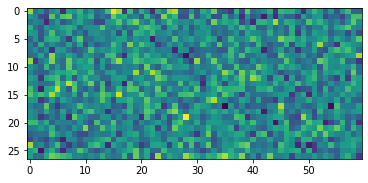

In [33]:
plt.imshow(c.detach())

In [34]:
Xtrain[3]

tensor([ 0,  0, 25, 21,  8])

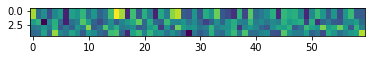

In [35]:
temp = c[Xtrain[3]]
plt.imshow(temp.detach())

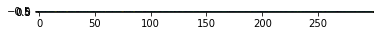

In [37]:
temp = temp.view(-1, 300)
plt.imshow(temp.detach())

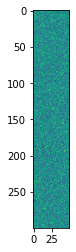

In [38]:
plt.imshow(w1.detach())

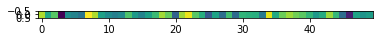

In [39]:
plt.imshow(b1.detach())

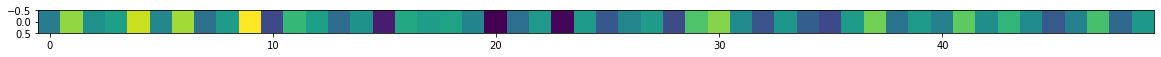

In [40]:
temp = temp @ w1 + b1
plt.figure(figsize=(20,2))
plt.imshow(temp.detach())


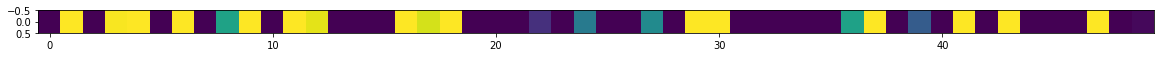

In [41]:
temp = torch.tanh(temp)
plt.figure(figsize=(20,2))
plt.imshow(temp.detach())

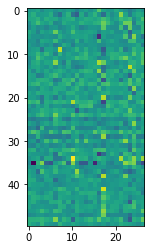

In [42]:
plt.imshow(w2.detach())

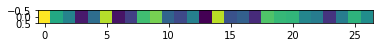

In [43]:
plt.imshow(b2.detach())

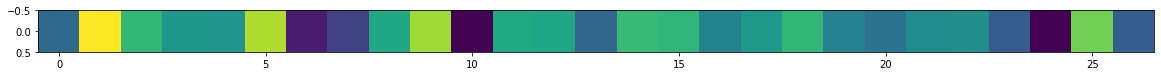

In [44]:
temp = temp @ w2 + b2

plt.figure(figsize=(20,2))
plt.imshow(temp.detach())

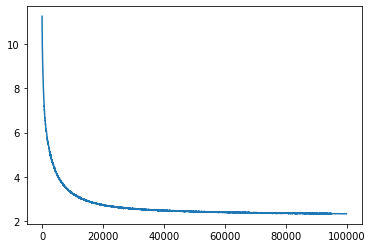

In [45]:
import numpy as np
train_moving_average = []

window = 100
for i in range(len(train_loss)- window + 1):
    train_moving_average.append(np.mean(train_loss[i:i+window]))

plt.plot(train_moving_average)
#plt.xscale('log')
#plt.yscale('log')

In [46]:
print(min(train_loss))

2.1223461627960205


In [47]:
g = torch.Generator().manual_seed(2147483647)
results = generate_names(c, 100, BLOCK_SIZE, w1, b1, w2, b2, g)

for result in results:
    print(''.join(itos[i] for i in result))

dexblaijah.
makila.
kaydie.
mzisthnain.
lusyn.
katar.
samiyah.
javhryima.
s.
moriel.
kauvi.
preda.
kaley.
maside.
enkaviyny.
fobsm.
hariten.
tarlasw.
dsdra.
aneil.
pyaw.
iarna.
razdy.
jayzur.
deru.
farit.
gaiban.
haabe.
arh.
kiyslee.
marril.
cayhur.
enan.
aleel.
mahalay.
caliysoe.
laiten.
mieag.
siseei.
enel.
ilemanlhkid.
merah.
ammigael.
mork.
ashc.
fmbalqanh.
ciorona.
veale.
azelne.
kay.
ralonai.
yvna.
iolsh.
aznich.
bahycah.
eallan.
anuute.
oramlilka.
radnek.
har.
vhlanda.
aalamia.
j.
ghnnry.
laarilrylm.
canro.
pnahaye.
vnaliegose.
ramer.
decla.
tiese.
paydahzy.
aleiza.
mztatpqpib.
oorni.
alkir.
jamerena.
raw.
liei.
tamaannel.
mademano.
seaday.
kayrena.
honso.
ikabsiynn.
micis.
amurahin.
jinasinn.
kediegz.
kihnad.
nosi.
kdanioh.
tistan.
marvanilaa.
ledike.
sajca.
zoraa.
alaica.
caima.
avallii.
